In [15]:
import sys
sys.path.append('../../../') # Add the root directory to sys.path

In [16]:
import torch
from torch import nn
from torch.optim.lr_scheduler import OneCycleLR
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

from torchsummary import summary
from models.starnet import StarNet
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight

In [17]:
data_dir = '../../../data/Gaia DR3/train.parquet'

In [18]:
data = pd.read_parquet(data_dir)
data.head(5)

,source_id,teff_gspphot,logg_gspphot,mh_gspphot,spectraltype_esphs,Cat,flux
0,2264606414026248192,5212.299316,4.4992,-1.2461,G,LM,"[2.6257292e-17, 2.8692712e-17, 3.0059525e-17, ..."
1,5242172756378861952,17552.250000,3.4490,0.4213,B,M,"[1.8050392e-14, 1.7178296e-14, 1.5548272e-14, ..."
2,2266498879696626944,5810.870605,3.9213,-0.5051,F,LM,"[3.292663e-17, 3.039652e-17, 2.9301113e-17, 3...."
3,5337670598285980160,14714.115234,3.8890,-0.2898,B,LM,"[1.2267033e-15, 1.2095414e-15, 1.155193e-15, 1..."
4,4063146749806089600,7999.921387,3.1459,-2.2106,B,M,"[2.0976588e-14, 2.2193906e-14, 2.1269509e-14, ..."


In [19]:
df = data.drop(columns = ['Cat', 'spectraltype_esphs'])
df.head()

,source_id,teff_gspphot,logg_gspphot,mh_gspphot,flux
0,2264606414026248192,5212.299316,4.4992,-1.2461,"[2.6257292e-17, 2.8692712e-17, 3.0059525e-17, ..."
1,5242172756378861952,17552.250000,3.4490,0.4213,"[1.8050392e-14, 1.7178296e-14, 1.5548272e-14, ..."
2,2266498879696626944,5810.870605,3.9213,-0.5051,"[3.292663e-17, 3.039652e-17, 2.9301113e-17, 3...."
3,5337670598285980160,14714.115234,3.8890,-0.2898,"[1.2267033e-15, 1.2095414e-15, 1.155193e-15, 1..."
4,4063146749806089600,7999.921387,3.1459,-2.2106,"[2.0976588e-14, 2.2193906e-14, 2.1269509e-14, ..."


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14101 entries, 0 to 14100
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   source_id     14101 non-null  int64  
 1   teff_gspphot  14101 non-null  float32
 2   logg_gspphot  14101 non-null  float32
 3   mh_gspphot    14101 non-null  float32
 4   flux          14101 non-null  object 
dtypes: float32(3), int64(1), object(1)
memory usage: 385.7+ KB


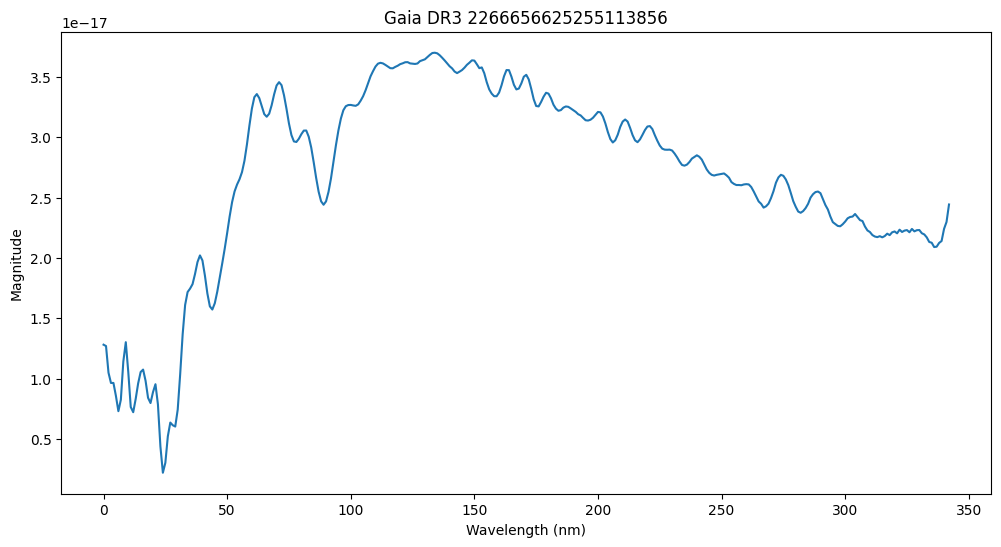

In [21]:
# rerun this cell to see random different spectra
sample_ms = df['flux'].sample(n=1).index
flux_ms = df['flux'].iloc[sample_ms].values[0]
object_id_ms = df['source_id'].iloc[sample_ms].values[0]

plt.figure(figsize=(12, 6))

plt.plot(flux_ms)
plt.title(f"Gaia DR3 {object_id_ms}")
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude')

plt.show()

In [22]:
num_samples = df.shape[0]
spectrum_width = len(df['flux'][0])

print("Number of total spectral samples:", num_samples)
print("Number of bins in each spectra:", spectrum_width)

Number of total spectral samples: 14101
Number of bins in each spectra: 343


In [23]:
X = np.vstack(df['flux'])
y = np.vstack(df[['teff_gspphot','logg_gspphot','mh_gspphot']].values)

# L2 normalization
X = torch.from_numpy(X/np.linalg.norm(X,keepdims=True)).float()

mean = np.mean(y, axis=0)
std = np.std(y, axis=0)

# Standardize the labels
y = torch.from_numpy((y - mean) / std)

In [30]:
def extend_curves(curves):
    '''
    function to extended loss curves to the same length
    '''
    max_length = max(len(curve) for curve in curves)
    
    extended_curves = []
    for curve in curves:
        last_value = curve[-1]
        extended_curve = curve + [last_value] * (max_length - len(curve))
        extended_curves.append(extended_curve)
    
    return np.array(extended_curves)

def init_weights(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
            
def fit_model(model, x_train, y_train, x_val, y_val, prt_steps = 1, verbose=True):
    
    # initialize weights
    model.apply(init_weights)

    # hyperparameters
    epochs = 200
    learning_rate = 1e-4
    batch_size = 32
    device = 'cuda'
    
    # early stopping
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # model components
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    # move everything to gpu
    model.to(device)
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    x_val = x_val.to(device)
    y_val = y_val.to(device)

    # metrics
    training_losses, validation_losses = [], []
    
    # lr cycling
    max_lr = 1e-2
    steps_per_epoch = (len(x_train) + batch_size - 1) // batch_size
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=steps_per_epoch, epochs=epochs)

    batch_start = torch.arange(0, len(x_train), batch_size)

    for epoch in tqdm(range(epochs), desc='Epochs', dynamic_ncols=True):
        
        model.train()
        running_loss = 0

        for start in batch_start:

            x_batch = x_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            print(x_batch.shape, y_batch.shape)
            output = model(x_batch.unsqueeze(1))
            loss = criterion(output, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item() * x_batch.size(0)

        train_loss = running_loss / len(x_train)
        training_losses.append(train_loss)
        if verbose and (epoch+1) % prt_steps == 0:
            print(f'Train loss: {train_loss:.4f}', end='\r')


        model.eval()
        
        with torch.no_grad():
            
            output = model(x_val.unsqueeze(1))
            loss = criterion(output, y_val)
            
            val_loss = loss.item()
        
        validation_losses.append(val_loss)
        
        if verbose and (epoch+1) % prt_steps == 0:
            print(f'Train loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}', end='\r')    
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'\nEarly stopping at epoch {epoch+1}')
            break
        
    return model, training_losses, validation_losses

In [ ]:
kfold = KFold(n_splits=5)

training_losses_foldx, validation_losses_foldx, models = [], [], []

params = {
    'num_fluxes':spectrum_width, 
    'filter_length':3, 
    'pool_length':4,
    'num_filters':[4,16],
    'num_hidden':[256,128],
    'num_labels':y.shape[1]
}

model = StarNet(**params)
summary(model, (1, spectrum_width))


for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
    
    print(f"\nFitting fold {fold+1}")

    model, tr_loss, val_loss = fit_model(model, X[train_idx], y[train_idx], X[val_idx], y[val_idx], prt_steps=1, verbose=True)
    models.append(model)
    training_losses_foldx.append(tr_loss)
    validation_losses_foldx.append(val_loss)

training_losses = np.mean(extend_curves(training_losses_foldx), axis=0)
validation_losses = np.mean(extend_curves(validation_losses_foldx), axis=0)

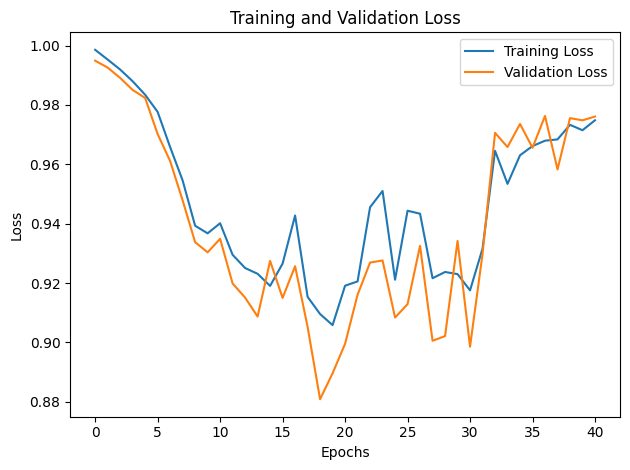

In [27]:
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()